<div style="text-align: center; color: #ffffff; font-family: Babas; font-size: 3em;">01. GRABEN - MONTESANTO</div>
<div style="text-align: left; color: #ffffff; font-family: Babas; font-size: 2.5em;">DESCRIPCIÓN</div>
<div style="text-align: left; color: #ffffff; font-family: Babas; font-size: 2em; border-bottom: 1px solid white;">Información obtenida de un corte geológico suroeste-noreste, ubicado en la plancha 39 – El Difícil. El modelo muestra un graben ocasionado por la falla normal Montesanto y otra falla que no aflora en superficie.  Este movimiento extensional afecta a las formaciones sedimentarias (areniscas) de Zambrano (N2z), Jesús del Monte (N1jm) compuesta por lodolitas, Rancho (N1r) y Ciénaga de Oro (E3N1co).  </div>

In [1]:
import gempy as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pyvista
import warnings
import pickle
from discretize.utils import mkvc, active_from_xyz
from discretize import TensorMesh

Setting Backend To: AvailableBackends.numpy


### 3D GEOLOGICAL MODEL

In [2]:
# load the model to check its ok
modelo = pickle.load(open(r"D:\PT_981\VCM.pickle", "rb"))

In [3]:
import gempy_viewer as gpv
gpv_obj = gpv.plot_3d(modelo, image=False, plotter_type='basic')

# B. ASSIGNMENT OF GEOPHYSICAL PROPERTIES

## Gravimetry


Usando estas columnas como X, Y, Z: ['X', 'Y', 'Zcorregido', 'Z']


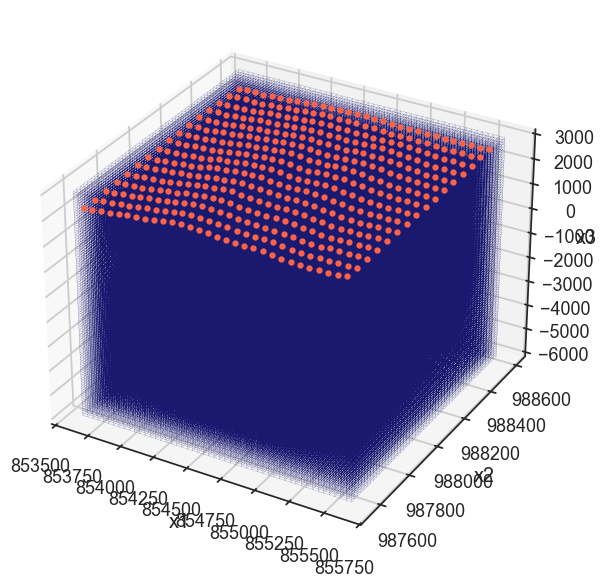

In [ ]:
import pandas as pd
import numpy as np

# leer archivo
#datos = pd.read_csv(r"9081\modelamiento\models\Replicated_points_0_2000_Y.csv", sep=',')
datos = pd.read_excel(r"9081\modelamiento\models\Datos_XYZ_480.xlsx")
# tomar las primeras 3 columnas (X, Y, Z) — comprobar que existan
columnas = datos.columns.tolist()[:4]
if len(columnas) < 3:
    raise ValueError(f"Se esperaban al menos 3 columnas (X,Y,Z). Columnas encontradas: {len(columnas)} -> {datos.columns.tolist()}")

print(f"\nUsando estas columnas como X, Y, Z: {columnas}")

# usar índices 0,1,2 (no 1,2,3)
x_topo = datos["X"]
y_topo = datos["Y"]
z_topo = datos["Z"]

x_topo = x_topo.to_numpy()
y_topo = y_topo.to_numpy()
z_topo = z_topo.to_numpy()

x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)

topo_xyz = np.c_[x_topo, y_topo, z_topo]


extent=[853610.2891, 855569.4948, 
            987530.5888, 988620.4712, 
            -6600, 3000]
dx = 40
ncx = 50
dy = 21
ncy = 50
dz = 180
ncz = 50


hx = [(dx, ncx)]
hy = [(dy, ncy)]
hz = [(dz, ncz)]
grid = TensorMesh([hx, hy, hz], x0=[853614, 987543, -6000])
# cell_centers = meshes.cell_centers
# xy_ravel=cell_centers
                           
grid.plot_grid(color="midnightblue", linewidth=0.1)
plt.plot(x_topo, y_topo, z_topo, '.', color='tomato')

In [ ]:
sol_block = gp.compute_model_at(modelo, grid.gridCC)

Active grids: GridTypes.NONE|TOPOGRAPHY|CUSTOM|DENSE
Setting Backend To: AvailableBackends.numpy
Chunking done: 52 chunks


In [ ]:

background_density = 2.9
densities = {
    0: background_density,  # Densidad del complejo metamórfico (g/cm³) #2.9
    1: 2.2,  # Densidad de Complejo_Dacitico                            #2.2
    2: 2.4,  # Densidad de Cuerpo_Intrusivo                             #2.4
    3: 2.5,  # Densidad de Flujo_Piroclastico                           #2.5
    4: 2.6,  # Densidad de Sucesion_Piroclastica                        #2.6
    5: 2.7   # Densidad de Sucesion_Volcanica                            #2.7
}

# Encontrar los índices para las celdas de malla activas (por ejemplo, celdas debajo de la superficie)
ind_active = active_from_xyz(grid, topo_xyz)

# Definir el mapeo del modelo a las celdas activas
nC = int(ind_active.sum())


In [ ]:
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps
from simpeg.potential_fields import gravity
model_map = maps.IdentityMap(nP=nC)

# Definir el modelo. Los modelos en SimPEG son arrays vectoriales.
model = np.zeros(nC)

# Mapear los valores de contraste de densidad del modelo GemPy al modelo SimPEG
for i, density in densities.items():
    ind_lith = sol_block[ind_active] == i
    model[ind_lith] = density - background_density 

In [ ]:
from scipy.interpolate import LinearNDInterpolator
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo) #Interpolación de los puntos xyz
z = fun_interp(np.c_[x_topo, y_topo]) + 5.0

datos = pd.read_excel(r"9081\modelamiento\models\VCM_Andes.xlsx")
x_topo = datos["Este(X)"]
y_topo = datos["Norte(Y)"]
z_topo = datos["Height"]

x_topo = x_topo.to_numpy()
y_topo = y_topo.to_numpy()
z_topo = z_topo.to_numpy()

x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
receiver_locations = np.c_[x_topo, y_topo, z]

components = ["gz"] # Se definen los componentes del campo que queremos simular con cadenas dentro de una lista
                    # Aqui solo se simula el componente vertical de la anomalía gravitatoria
receiver_list = gravity.receivers.Point(receiver_locations, components=components)
receiver_list = [receiver_list]   #Se usan las ubicaciones de observación y los componentes para definir los receptores
                                  #Para simular dichos datos, los receptores deben definirse como una lista
source_field = gravity.sources.SourceField(receiver_list=receiver_list) #Definir el campo de origen

survey = gravity.survey.Survey(source_field)
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=grid,
    rhoMap=model_map,
    ind_active=ind_active,
    store_sensitivities="forward_only",
    engine="geoana",
)


# Realizar la simulación directa
d_pred = simulation.dpred(model)

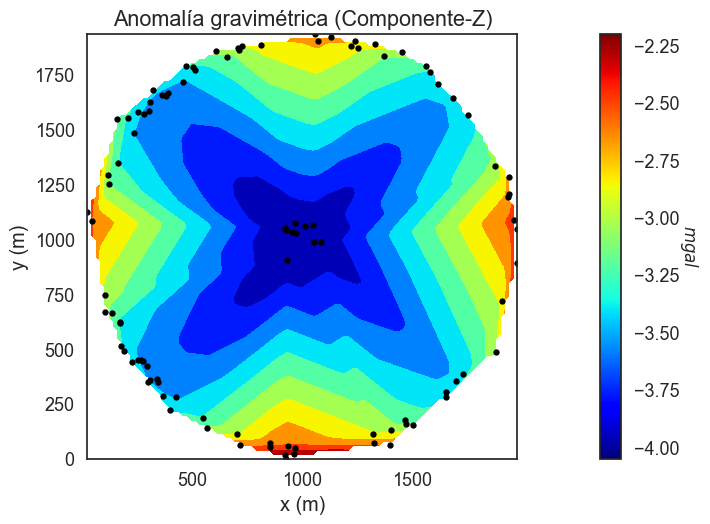

In [ ]:
from SimPEG.utils import plot2Ddata, model_builder
import matplotlib as mpl
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list[0].locations, -d_pred, ax=ax1, contourOpts={"cmap": "jet"})
ax1.set_title("Anomalía gravimétrica (Componente-Z)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")


plt.plot(x_topo, y_topo, '.', color='black', )

ax2 = fig.add_axes([0.90, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(d_pred)), vmax=np.max(-d_pred))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap="jet", #format="%.0e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()